In [1]:
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import pandas as pd
import numpy as np
import seaborn as sns
import netCDF4
from itertools import permutations

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime

from sklearn.linear_model import LinearRegression
import optuna
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from khiops.sklearn import KhiopsClassifier

import re
from tqdm import tqdm

c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit


In [2]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
path = 'E:/individus_filtered/'
# freqs = [50, 100, 200, 300, 500, 1000, 2500, 5000, 8000, 10000, 12000, 15000]
freqs = [500, 1000, 2500, 5000, 8000, 10000, 12000, 15000, 16000,20000]
features_csv = ['downwards_mean_500', 'downwards_mean_1000', 'downwards_mean_2500',
       'downwards_mean_5000', 'downwards_mean_8000', 'downwards_mean_10000',
       'downwards_mean_12000', 'downwards_mean_15000', 'downwards_mean_16000','upwards_mean_20000','upwards_mean_5000']

# Insertion SPL .csv

In [ ]:
depid="ml17_280a"
inst = Wind(depid=depid, path=os.path.join(path,depid), acoustic_path=os.path.join(path,depid,'dives'))
inst.fetch_data(method = 'upwards', aggregation = 'mean', frequency = 15000)


c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit\applications\Wind.py:129: RuntimeWarning: Mean of empty slice
  spl.append(agg(_data['spectro'][np.isin(_data['time'], time_mask), idx_freq]))
c:\Users\barsro\Documents\SES_tags\notebooks\../src\Biologging_Toolkit\applications\Wind.py:130: RuntimeWarning: Mean of empty slice
  wind_speed.append(agg(dive.ds['wind_speed'][:].data[(dive.ds['dives'][:].data == row.dive) & mask]))


# Ajout de Spectral Slope

In [ ]:
depid = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
df['slope_8_15'] = df['upwards_mean_15000'] / df['upwards_mean_8000']

df.to_csv(path + f'/{depid}/{depid}_dive.csv', index=False)

# Visualisation Spectrogrammes

In [24]:
depid = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = "precipitation_GPM"
factor = 1000 if feature.startswith('tp') else 1

rain_df = df.loc[df[feature]*factor>=1]
noRain_df = df.loc[df[feature]*factor<1]
wind_df = df.loc[df["wind_speed"]*factor>=10]

d_df = [datetime.fromtimestamp(ts) for ts in df['begin_time']]
d_wdf = [datetime.fromtimestamp(ts) for ts in wind_df['begin_time']]
d_Rdf = [datetime.fromtimestamp(ts) for ts in rain_df['begin_time']]
d_NRdf = [datetime.fromtimestamp(ts) for ts in noRain_df['begin_time']]

In [ ]:
fig = px.scatter(
    df,
    x=d_df,
    y=df[feature] * factor,
    color=df["wind_speed"],
    color_continuous_scale="Viridis",
    hover_data={'dive_number': df["dive"],'wind(m/s)': df["wind_speed"]},
    title = f'Visualisation pluie pour dataset {depid} : {feature}'
)

fig.add_trace(px.line(df, x=d_df, y=df[feature] * factor).data[0])

fig.update_layout(
    xaxis=dict(
        tickformat='%b %d',
    ),
    coloraxis_colorbar=dict(
        title="Wind Speed (m/s)"
    ),
    xaxis_title='Date',
    yaxis_title=feature,
)

fig.show()

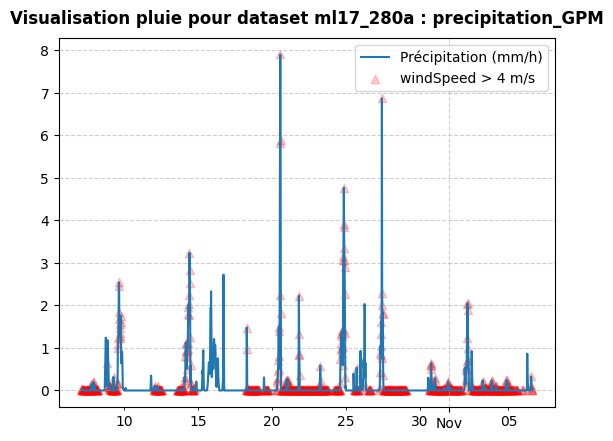

In [27]:
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.gca().xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[5,10,15,20,25,30])) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

plt.title(f'Visualisation pluie pour dataset {depid} : {feature}', fontsize=12, fontweight='bold', pad=10)
plt.plot(d_df, df[feature]*factor, label = "Précipitation (mm/h)")
plt.scatter(d_wdf,wind_df[feature]*factor, c="red", marker="^", label="windSpeed > 4 m/s", alpha=0.2)
# plt.scatter(d_Rdf,rain_df[feature]*factor, c="red", marker="^", label="Précipitations > 1mm/h")
# plt.scatter(d_NRdf,noRain_df[feature]*factor, c="black", marker="x", label="Précipitations > 1mm/h", alpha=0.2)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

In [32]:
def plot_spectro(dive_number=0, path='E:/individus_filtered/', depid = 'ml17_280a'):
    spectr_path = f"{path}{depid}/dives/acoustic_dive_{dive_number:05}.npz"
    data = np.load(spectr_path)
    df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')

    time = data['time']
    freq = data['freq']
    plt.figure(figsize=(20,5)) 
    plt.imshow(data["spectro"], aspect='auto', cmap='viridis', interpolation='none',
            extent=[(time.min()-time.min())/60, (time.max()-time.min())/60, freq.min(), freq.max()], vmin=-100, vmax=50)
    plt.colorbar(label='Intensity')
    plt.xlabel('Time (min)')
    plt.ylabel('Frequency (Hz)')

    try:
        plt.title(f'Spectrogramme {depid} plongée n°{dive_number}\n {feature}={round(df[feature][dive_number]*factor,1)}mm/h, NystuenReg={round(opt_results_RE_Nystuen_8KHz[dive_number],1)}mm/h wind={round(df["wind_speed"][dive_number],1)}m/s ', fontsize=12, fontweight='bold', pad=10)
    except NameError:
        plt.title(f'Spectrogramme {depid} plongée n°{dive_number}\n {feature}={round(df[feature][dive_number]*factor,3)}mm/h, wind={df["wind_speed"][dive_number]}m/s', fontsize=12, fontweight='bold', pad=10)
    plt.show()

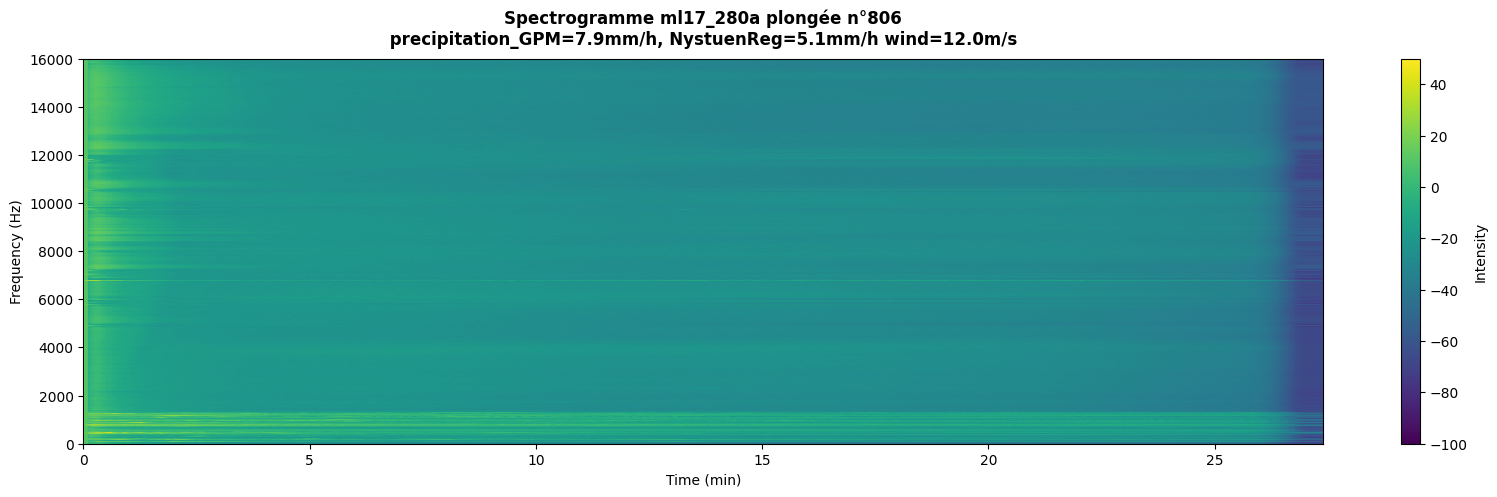

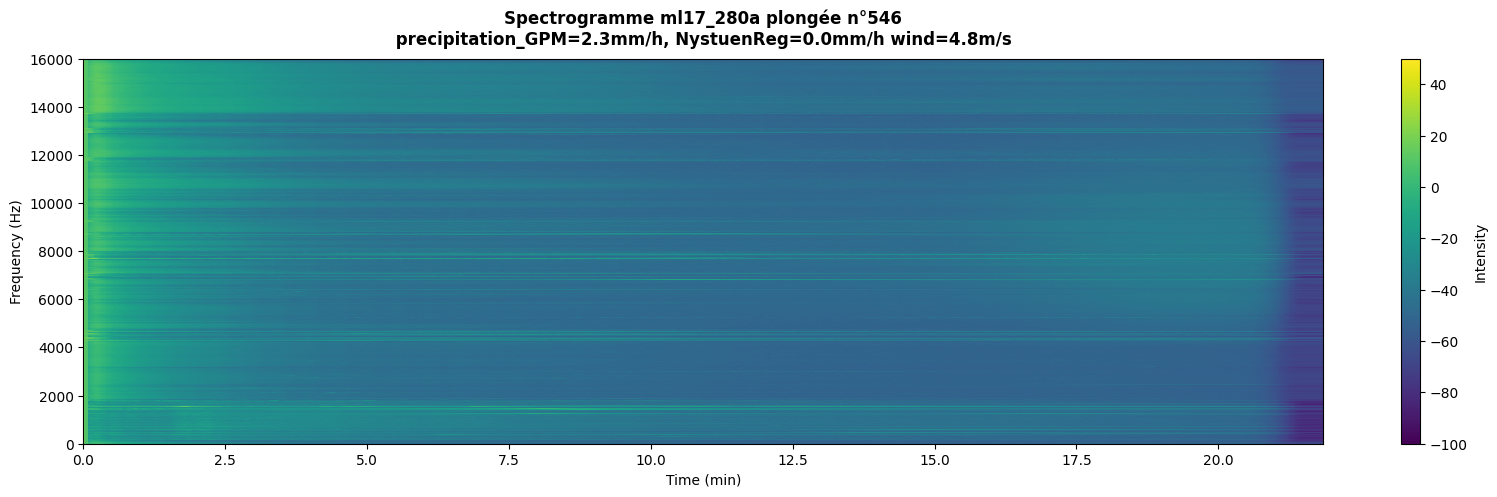

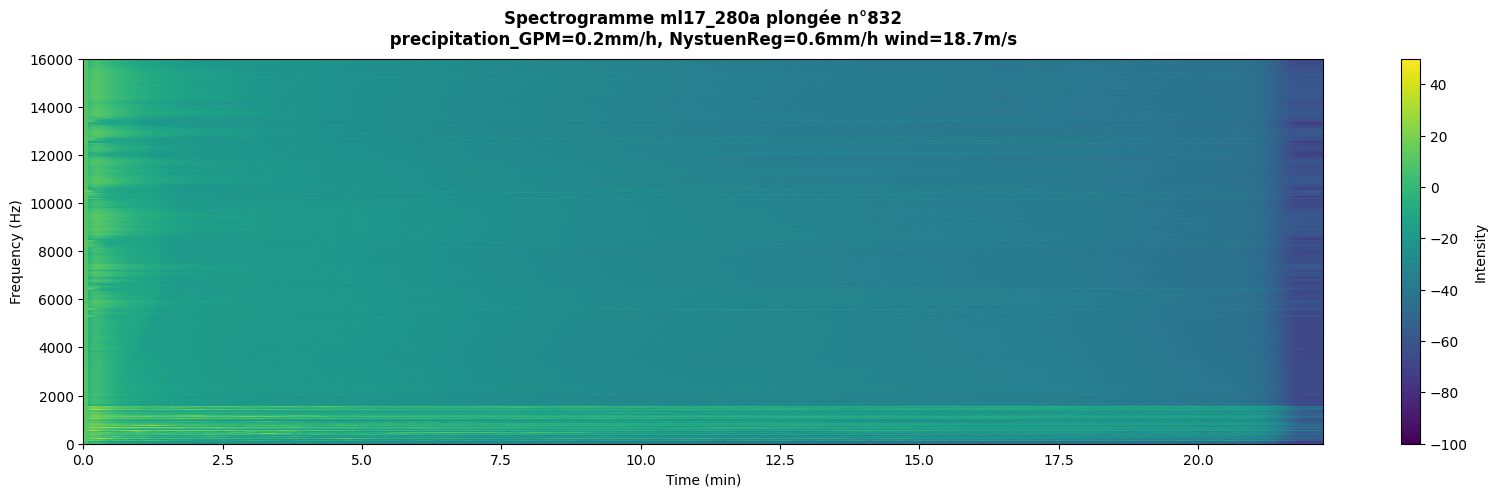

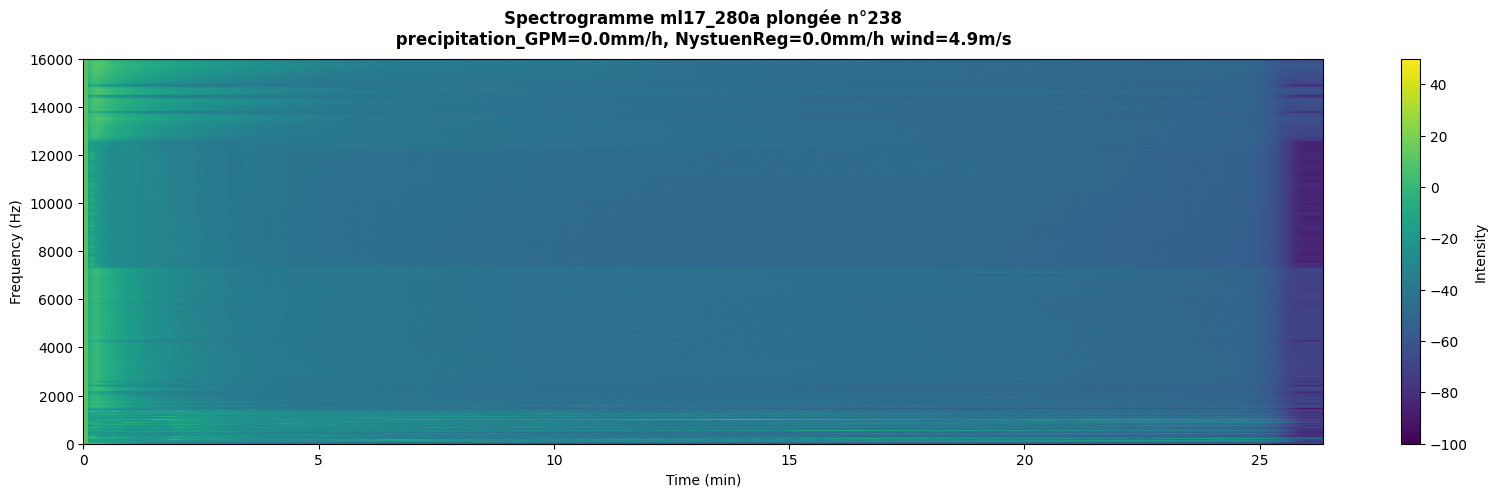

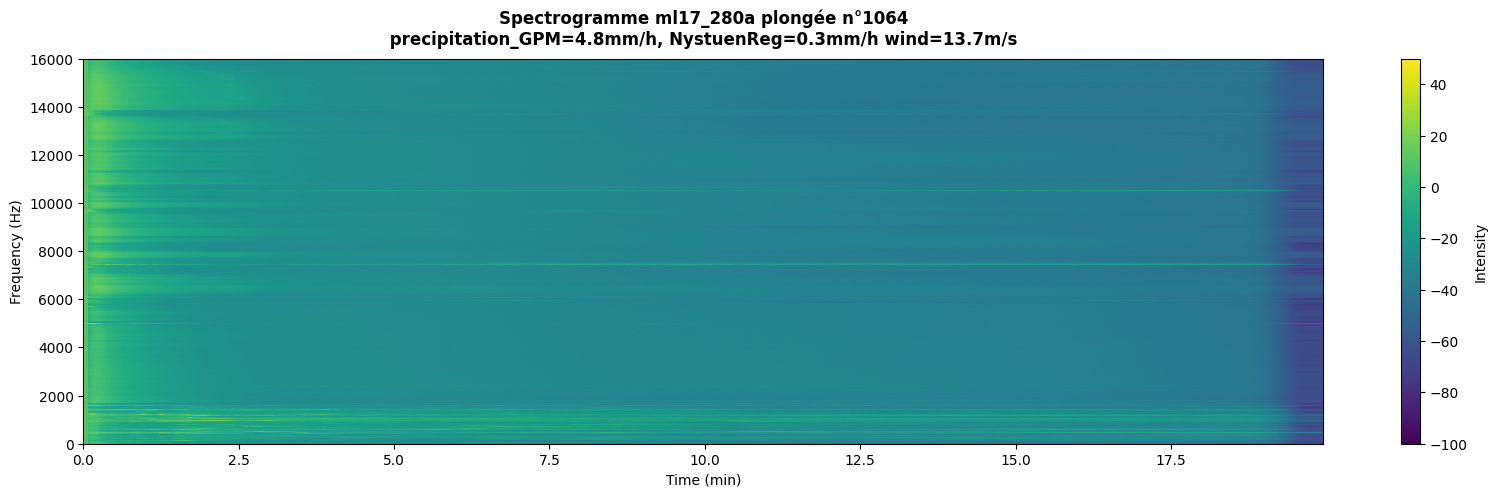

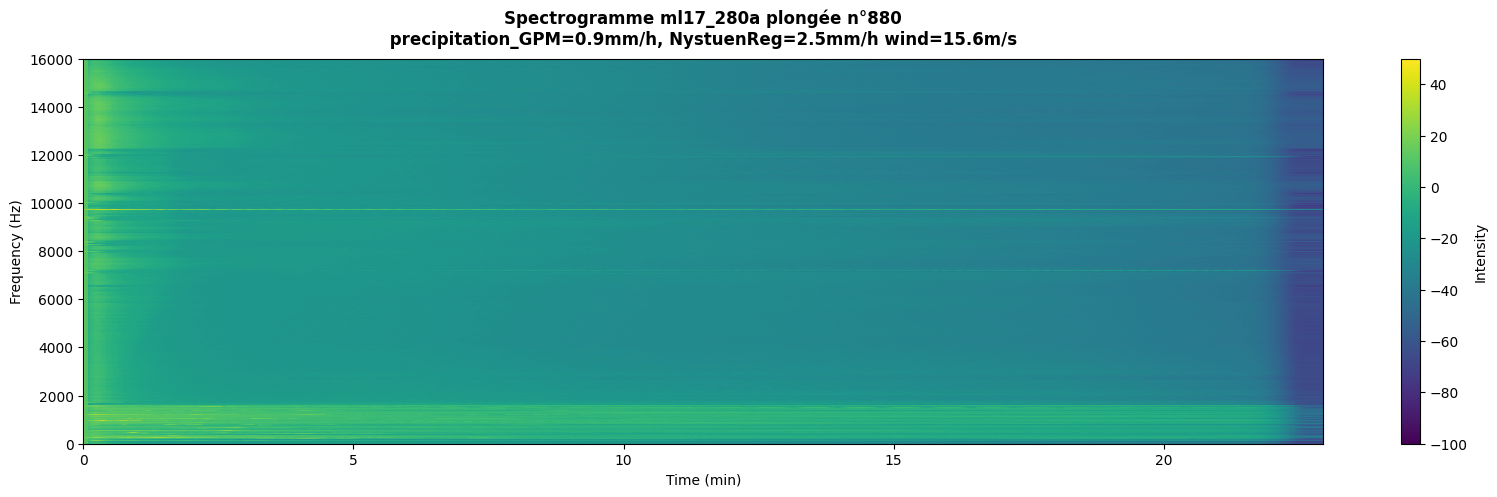

In [34]:
dive_list = [806, 546, 832, 238, 1064, 880]
for dive in dive_list :
    plot_spectro(dive_number=dive)

# plot_spectro(dive_number=int(rain_df["dive"].iloc[0]))
# plot_spectro(dive_number=int(noRain_df["dive"].iloc[0]))

## Benchmark de différents algorithmes empiriques pour la detection et l'estimation d'évenements pluvieux
#### 1-Detection:
- Ma et Nystuen, 2005, "Passive Acoustic Detection and Measurement of Rainfall at Sea"
- Nystuen, 2014, "Monitoring Greek Seas Using Passive Underwater Acoustics"
- Nystuen, 1997, "Weather Classification Using Passive Acoustic Drifters"

#### 2-Estimation:
- KK Noufal, 2025, "Rainfall estimation through ambient noise measurements in the deep waters of the southeast Arabian Sea"
- Anagnostou, 2008, "Evaluation of Underwater Rainfall Measurements During the Ionian Sea Rainfall Experiment"
- Pensieri, 2015, "Evaluation of Underwater Rainfall Measurements During the Ionian Sea Rainfall Experiment"
- Nystuen, 2014, "Monitoring Greek Seas Using Passive Underwater Acoustics"
- Ma et Nystuen, 2005, "Passive Acoustic Detection and Measurement of Rainfall at Sea"
- Nystuen, 1997, "Weather Classification Using Passive Acoustic Drifters"

C:\Users\barsro\AppData\Local\Temp\ipykernel_12956\1476773111.py:48: RuntimeWarning: Mean of empty slice
  mean_spl = np.nanmean(value, axis=0)
c:\Users\barsro\.conda\envs\rain\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


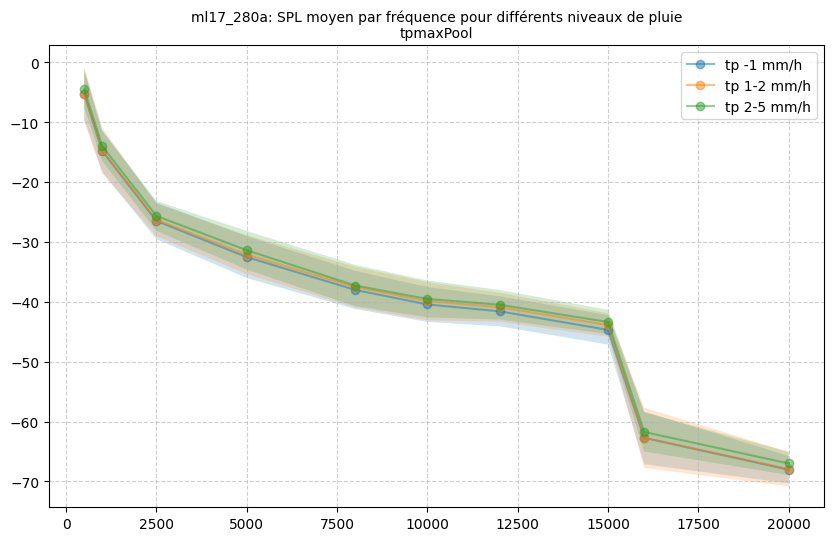

In [86]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
precip_value = 'tpmaxPool'

spll = {"-1": [], "1-2": [], "2-5": [], "5-": []}

for row in df.iterrows():
    row = row[1]
    
    if row[precip_value] < 0.001 :
        spl_000  = []
        for freq in freqs:
            if freq == 20000:
                spl_000.append(row[f"upwards_mean_{freq}"])
            else:
                spl_000.append(row[f"downwards_mean_{freq}"])
        spll["-1"].append(spl_000)

    elif 0.001 < row[precip_value] < 0.002 :
        spl_001 = []
        for freq in freqs:
            if freq == 20000:
                spl_001.append(row[f"upwards_mean_{freq}"])
            else:
                spl_001.append(row[f"downwards_mean_{freq}"])
        spll["1-2"].append(spl_001)

    elif 0.002 < row[precip_value] < 0.005 :
        spl_002 = []
        for freq in freqs:
            if freq == 20000:
                spl_002.append(row[f"upwards_mean_{freq}"])
            else:
                spl_002.append(row[f"downwards_mean_{freq}"])
        spll["2-5"].append(spl_002)

    elif row[precip_value] > 0.005 :
        spl_005 = []
        for freq in freqs:
            if freq == 20000:
                spl_005.append(row[f"upwards_mean_{freq}"])
            else:
                spl_005.append(row[f"downwards_mean_{freq}"])
        spll["5-"].append(spl_005)

plt.figure(figsize=(10, 6))
for key, value in spll.items():
    mean_spl = np.nanmean(value, axis=0)
    std_spl = np.nanstd(value, axis=0)
    if value != [] :
    # print(f"{key} : {len(value)} - {mean_spl} - {std_spl}")
        plt.plot(freqs, mean_spl, marker='o', alpha=0.5, label=f"tp {key} mm/h")
        plt.fill_between(freqs, mean_spl - std_spl, mean_spl + std_spl, alpha=0.2)
plt.legend(loc='upper right')
plt.title(f"{depid}: SPL moyen par fréquence pour différents niveaux de pluie\n{precip_value}", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()




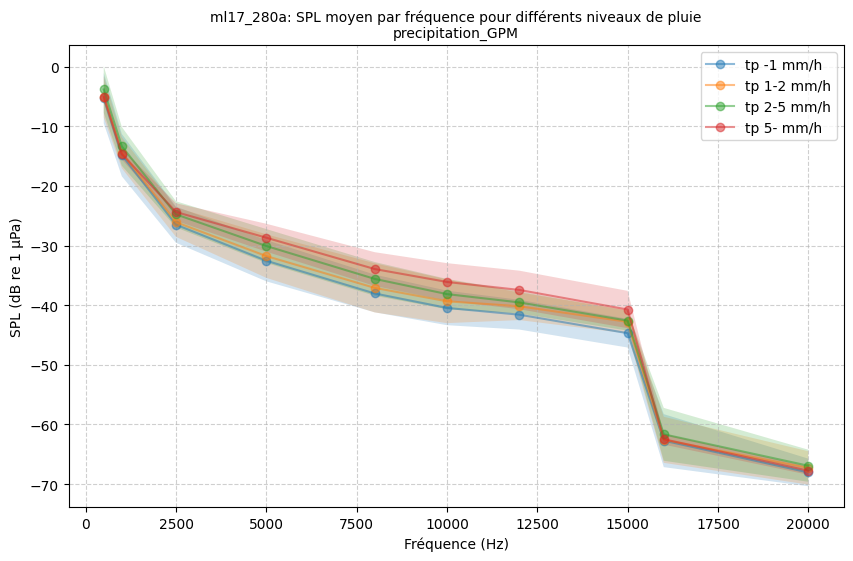

In [92]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
precip_value = 'precipitation_GPM'

spll = {"-1": [], "1-2": [], "2-5": [], "5-": []}

for row in df.iterrows():
    row = row[1]
    
    if row[precip_value] < 1 :
        spl_000  = []
        for freq in freqs:
            if freq == 20000:
                spl_000.append(row[f"upwards_mean_{freq}"])
            else:
                spl_000.append(row[f"downwards_mean_{freq}"])
        spll["-1"].append(spl_000)

    elif 1 < row[precip_value] < 2 :
        spl_001 = []
        for freq in freqs:
            if freq == 20000:
                spl_001.append(row[f"upwards_mean_{freq}"])
            else:
                spl_001.append(row[f"downwards_mean_{freq}"])
        spll["1-2"].append(spl_001)

    elif 2 < row[precip_value] < 5 :
        spl_002 = []
        for freq in freqs:
            if freq == 20000:
                spl_002.append(row[f"upwards_mean_{freq}"])
            else:
                spl_002.append(row[f"downwards_mean_{freq}"])
        spll["2-5"].append(spl_002)

    elif row[precip_value] > 5 :
        spl_005 = []
        for freq in freqs:
            if freq == 20000:
                spl_005.append(row[f"upwards_mean_{freq}"])
            else:
                spl_005.append(row[f"downwards_mean_{freq}"])
        spll["5-"].append(spl_005)

plt.figure(figsize=(10, 6))
for key, value in spll.items():
    mean_spl = np.nanmean(value, axis=0)
    std_spl = np.nanstd(value, axis=0)
    # print(f"{key} : {len(value)} - {mean_spl} - {std_spl}")
    plt.plot(freqs, mean_spl, marker='o', alpha=0.5, label=f"tp {key} mm/h")
    plt.fill_between(freqs, mean_spl - std_spl, mean_spl + std_spl, alpha=0.2)
plt.legend(loc='upper right')
plt.title(f"{depid}: SPL moyen par fréquence pour différents niveaux de pluie\n{precip_value}", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlabel("Fréquence (Hz)")
plt.ylabel("SPL (dB re 1 µPa)")
plt.show()



# 1 Detection
### Fonctions des méthodes empiriques de la litterature

In [47]:
def detect_rain_from_ds(df, feature, factor):
    df["Rain_Type"] = "None"
    intensity = df[feature] * factor

    df.loc[(intensity > 0.01) & (intensity <= 1), "Rain_Type"] = "D"
    df.loc[(intensity > 1) & (intensity <= 7.5), "Rain_Type"] = "MR"
    df.loc[intensity > 7.5, "Rain_Type"] = "HR"
    df.loc[(intensity > 1) & (df["wind_speed"] > 4), "Rain_Type"] = "RW"

    return df

In [48]:
depid = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = "tpmaxPool"
factor = 1000 if feature.startswith('tp') else 1
df = df.dropna(subset=["begin_time", "upwards_mean_5000", "upwards_mean_8000", "wind_speed", feature])

df = detect_rain_from_ds(df, feature, factor)
df.head()

,dive,begin_time,end_time,zn1,zn2,zn1_up,zn2_up,zn1_down,zn2_down,threhsold_up,...,tp,upwards_mean_20000,tpmaxPool,precipitation_GPM,upwards_mean_8000,upwards_mean_2000,upwards_mean_15000,slope_2_8,slope_8_15,Rain_Type
0,0.0,1.507334e+09,1.507335e+09,NaN,NaN,NaN,NaN,NaN,NaN,157.202545,...,NaN,-66.859617,0.000030,NaN,-30.243108,-22.693514,-40.239264,-12.539605,-36.615783,D
1,1.0,1.507335e+09,1.507337e+09,NaN,NaN,NaN,NaN,NaN,NaN,134.639832,...,0.000146,-66.281385,0.000199,0.014598,-31.205862,-23.300551,-40.976989,-13.130437,-35.791508,D
2,2.0,1.507337e+09,1.507338e+09,NaN,NaN,NaN,NaN,NaN,NaN,125.335068,...,0.000125,-66.525741,0.000199,0.020260,-31.240039,-23.422424,-40.866807,-12.984778,-35.262722,D
3,3.0,1.507338e+09,1.507339e+09,NaN,NaN,NaN,NaN,NaN,NaN,124.460243,...,0.000105,-65.920599,0.000199,0.025509,-31.636330,-23.600871,-40.995801,-13.346609,-34.283617,D
4,4.0,1.507339e+09,1.507341e+09,NaN,NaN,NaN,NaN,NaN,NaN,133.336792,...,0.000127,-66.512066,0.000199,0.043237,-32.478479,-24.544256,-41.725463,-13.178458,-33.871580,D


In [49]:
def DE_Nystuen_2014(
    df,
    offset20=0,
    offset15=0,
    offset8=0,
    offset5=0,
    cond1_slope=0.75,
    cond1_offset=5,
    cond1_max5000=70,
    cond2_min8000=60,
    cond2_min_slope_2_8=-13,
    cond2_min20000=45,
    cond3_max8000=50,
    cond3_min_slope_8_15=-5,
    cond3_min20000=35,
    cond3_ratio8000=0.9,
    cond4_quad1=-0.1144,
    cond4_lin1=12.728,
    cond4_const1=-307,
    cond4_quad2=-0.1,
    cond4_lin2=11.5,
    cond4_const2=-281,
    cond4_min8000=51,
    cond4_max8000=64,
    cond4_min_slope_2_8=-13
):
    df = df.copy()
    df['upwards_mean_20000'] += offset20
    df['upwards_mean_5000'] += offset5
    df['upwards_mean_8000'] += offset8
    df['upwards_mean_15000'] += offset15

    conditions = [
        # Medium rain (stratiform)
        (df['upwards_mean_20000'] > df['upwards_mean_5000'] * cond1_slope + cond1_offset) &
        (df['upwards_mean_5000'] <= cond1_max5000),

        # Heavy rain (convective)
        (df['upwards_mean_8000'] > cond2_min8000) &
        (df['slope_2_8'] > cond2_min_slope_2_8) &
        (df['upwards_mean_20000'] > cond2_min20000),

        # Drizzle
        (df['upwards_mean_8000'] < cond3_max8000) &
        (df['slope_8_15'] > cond3_min_slope_8_15) &
        (df['upwards_mean_20000'] > cond3_min20000) &
        (df['upwards_mean_20000'] > df['upwards_mean_8000'] * cond3_ratio8000),

        # Rain with high winds
        (df['upwards_mean_20000'] > (cond4_quad1 * df['upwards_mean_8000']**2 + cond4_lin1 * df['upwards_mean_8000'] + cond4_const1)) &
        (df['upwards_mean_20000'] < (cond4_quad2 * df['upwards_mean_8000']**2 + cond4_lin2 * df['upwards_mean_8000'] + cond4_const2)) &
        (df['upwards_mean_8000'] > cond4_min8000) &
        (df['upwards_mean_8000'] < cond4_max8000) &
        (df['slope_2_8'] > cond4_min_slope_2_8)
    ]

    choices = ['MR', 'HR', 'D', 'RW']
    df['Rain_Type_Preds'] = np.select(conditions, choices, default='None')
    return df


In [50]:
def objective_DE_Nystuen_2014(trial):
    
    # params = {
    #     "offset20": trial.suggest_float("offset20", 0, 100),
    #     "offset15": trial.suggest_float("offset15", 0, 100),
    #     "offset8": trial.suggest_float("offset8", 0, 100),
    #     "offset5": trial.suggest_float("offset5", 0, 100),
    #     "cond1_slope": trial.suggest_float("cond1_slope", 0.5, 1.0),
    #     "cond1_offset": trial.suggest_float("cond1_offset", 0, 10),
    #     "cond1_max5000": trial.suggest_float("cond1_max5000", 60, 80),
    #     "cond2_min8000": trial.suggest_float("cond2_min8000", 50, 70),
    #     "cond2_min_slope_2_8": trial.suggest_float("cond2_min_slope_2_8", -20, -5),
    #     "cond2_min20000": trial.suggest_float("cond2_min20000", 30, 60),
    #     "cond3_max8000": trial.suggest_float("cond3_max8000", 40, 60),
    #     "cond3_min_slope_8_15": trial.suggest_float("cond3_min_slope_8_15", -10, 0),
    #     "cond3_min20000": trial.suggest_float("cond3_min20000", 30, 50),
    #     "cond3_ratio8000": trial.suggest_float("cond3_ratio8000", 0.7, 1.0),
    #     "cond4_quad1": trial.suggest_float("cond4_quad1", -0.2, -0.05),
    #     "cond4_lin1": trial.suggest_float("cond4_lin1", 10, 15),
    #     "cond4_const1": trial.suggest_float("cond4_const1", -350, -250),
    #     "cond4_quad2": trial.suggest_float("cond4_quad2", -0.2, -0.05),
    #     "cond4_lin2": trial.suggest_float("cond4_lin2", 10, 15),
    #     "cond4_const2": trial.suggest_float("cond4_const2", -350, -250),
    #     "cond4_min8000": trial.suggest_float("cond4_min8000", 45, 55),
    #     "cond4_max8000": trial.suggest_float("cond4_max8000", 60, 70),
    #     "cond4_min_slope_2_8": trial.suggest_float("cond4_min_slope_2_8", -20, -5),
    # }
    params = {
    "offset20": trial.suggest_float("offset20", 0, 100),
    "offset15": trial.suggest_float("offset15", 00, 100),
    "offset8": trial.suggest_float("offset8", 0, 100),
    "offset5": trial.suggest_float("offset5", 0, 100),
    "cond1_slope": trial.suggest_float("cond1_slope", 0, 3.0),
    "cond1_offset": trial.suggest_float("cond1_offset", -10, 30),
    "cond1_max5000": trial.suggest_float("cond1_max5000", 40, 120),
    "cond2_min8000": trial.suggest_float("cond2_min8000", 30, 90),
    "cond2_min_slope_2_8": trial.suggest_float("cond2_min_slope_2_8", -40, 10),
    "cond2_min20000": trial.suggest_float("cond2_min20000", 10, 80),
    "cond3_max8000": trial.suggest_float("cond3_max8000", 20, 80),
    "cond3_min_slope_8_15": trial.suggest_float("cond3_min_slope_8_15", -30, 20),
    "cond3_min20000": trial.suggest_float("cond3_min20000", 10, 70),
    "cond3_ratio8000": trial.suggest_float("cond3_ratio8000", 0.4, 2.0),
    "cond4_quad1": trial.suggest_float("cond4_quad1", -0.5, 0.1),
    "cond4_lin1": trial.suggest_float("cond4_lin1", 0, 30),
    "cond4_const1": trial.suggest_float("cond4_const1", -500, -150),
    "cond4_quad2": trial.suggest_float("cond4_quad2", -0.5, 0.1),
    "cond4_lin2": trial.suggest_float("cond4_lin2", 0, 30),
    "cond4_const2": trial.suggest_float("cond4_const2", -500, -150),
    "cond4_min8000": trial.suggest_float("cond4_min8000", 30, 70),
    "cond4_max8000": trial.suggest_float("cond4_max8000", 50, 85),
    "cond4_min_slope_2_8": trial.suggest_float("cond4_min_slope_2_8", -40, 10),
    }

    df_pred = DE_Nystuen_2014(df, **params)
    return 1.0 - f1_score(df["Rain_Type"], df_pred["Rain_Type_Preds"], average="weighted")  

In [51]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='minimize')
study.optimize(objective_DE_Nystuen_2014, n_trials=200, show_progress_bar=True)
best_params = study.best_params
print(best_params)
opt_results_class = DE_Nystuen_2014(df, **best_params)

  0%|          | 0/200 [00:00<?, ?it/s]

{'offset20': 63.94075020837773, 'offset15': 62.4888066629114, 'offset8': 46.892548296760566, 'offset5': 34.25468883860225, 'cond1_slope': 2.9438985156607553, 'cond1_offset': 17.975079204230408, 'cond1_max5000': 74.88600768722144, 'cond2_min8000': 79.41597110858146, 'cond2_min_slope_2_8': 2.1137846164348524, 'cond2_min20000': 71.71260385847813, 'cond3_max8000': 69.84353153790073, 'cond3_min_slope_8_15': -3.415201559632646, 'cond3_min20000': 68.57828333734312, 'cond3_ratio8000': 1.1327756715834458, 'cond4_quad1': 0.07340281755223772, 'cond4_lin1': 28.226155174525385, 'cond4_const1': -443.5847765559537, 'cond4_quad2': -0.1934837903304935, 'cond4_lin2': 6.385328177783316, 'cond4_const2': -305.75109280326444, 'cond4_min8000': 55.146662254298555, 'cond4_max8000': 67.48979139453476, 'cond4_min_slope_2_8': -2.2705953557663365}


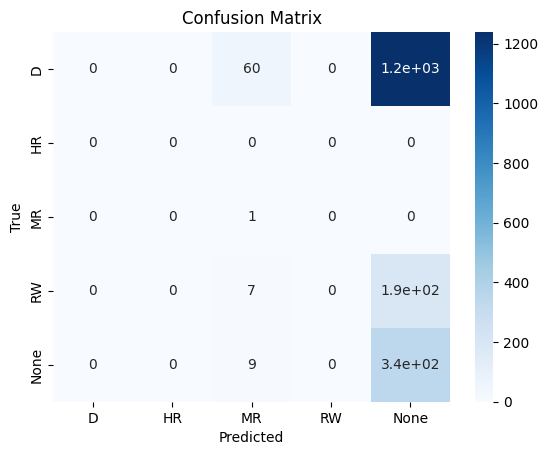

In [52]:
labels = ["D", "HR", "MR", "RW", "None"]
cf_matrix = confusion_matrix(df["Rain_Type"], opt_results_class["Rain_Type_Preds"], labels=labels)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Khiops Classifier

In [59]:
def detect_binary_rain_from_ds(df, feature, factor):
    df["Rain_Type"] = "None"
    intensity = df[feature] * factor 

    df.loc[(intensity >= 1) , "Binary_Rain_Type"] = 1
    df.loc[(intensity <1) , "Binary_Rain_Type"] = 0

    return df

In [84]:
depid = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = "tpmaxPool"
factor = 1000 if feature.startswith('tp') else 1
# df = df.dropna(subset=["begin_time", "upwards_mean_5000", "upwards_mean_8000", "wind_speed", feature])
df = detect_binary_rain_from_ds(df, feature, factor)

df = df[["upwards_mean_2000", "upwards_mean_5000", "upwards_mean_8000", "upwards_mean_15000", "upwards_mean_20000","Binary_Rain_Type"]]
print(df["Binary_Rain_Type"].value_counts())

Binary_Rain_Type
0.0    1658
1.0     201
Name: count, dtype: int64


In [85]:
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=1,
    stratify=df["Binary_Rain_Type"]
)

X_train = train_df.drop("Binary_Rain_Type", axis=1)
X_test = test_df.drop("Binary_Rain_Type", axis=1)
y_train = train_df["Binary_Rain_Type"]
y_test = test_df["Binary_Rain_Type"]

khc = KhiopsClassifier(n_trees=500)

khc.fit(X_train, y_train)
y_test_pred = khc.predict(X_test)

Test R2  = -0.12048192771084332
Test MAE = 0.10752688172043011


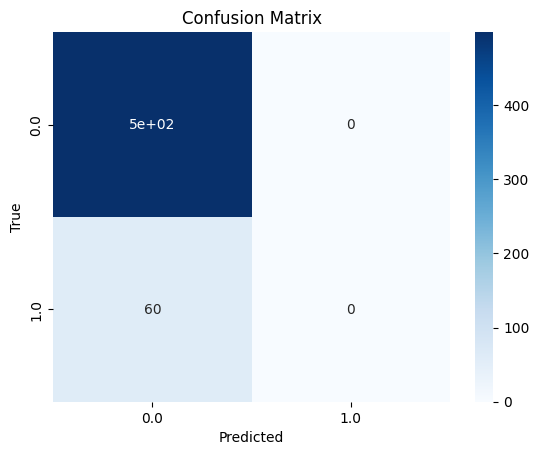

In [86]:
test_r2 = metrics.r2_score(y_test, y_test_pred)
test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
print(f"Test R2  = {test_r2}")
print(f"Test MAE = {test_mae}")
labels = [0.0, 1.0]
cf_matrix = confusion_matrix(y_test, y_test_pred, labels=labels)
sns.heatmap(cf_matrix, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2 Estimation
### Fonction des méthodes empiriques de la litterature

In [3]:
depid = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feature = "precipitation_GPM"
factor = 1000 if feature.startswith('tp') else 1
df = df.dropna(subset=["begin_time", "upwards_mean_5000", "upwards_mean_8000", "upwards_mean_2000", "wind_speed", feature])


In [4]:
def RE_KKNoufal_2025(df, FKHz=8000, a=14.76, b=44.93, c=5.66, d=15.75, off=0):
    SPL_1_10kHz = df[f'upwards_mean_{FKHz}'] + off
    log_f = np.log10(FKHz)
    log_5 = np.log10(5)
    R = (SPL_1_10kHz + (log_f - log_5) * a - b) / ((log_f - log_5) * c + d)
    return R

def RE_Nystuen_2014(df, a=0.0325, b=1.4416, off=0):
    SPL_5Khz = df['upwards_mean_5000'] + off
    R = (10**(a*SPL_5Khz - b) )
    return R

def RE_Nystuen_1997(df, a=51.9, b=10.6, off=0):
    SPL_5Khz = df['upwards_mean_5000'] + off
    R = (10**((SPL_5Khz - a)/b))
    return R

def RE_Nystuen_2004(df, a=42.5, b=15.4, off=0):
    SPL_5Khz = df['upwards_mean_5000'] + off
    R = (10**((SPL_5Khz - a)/b))
    return R

def RE_Nystuen_8KHz(df, a=42.5, b=15.4, off=0):
    SPL_5Khz = df['upwards_mean_8000'] + off
    R = (10**((SPL_5Khz - a)/b))
    return R

def RE_Pensieri_2014(df):
    SPL_5Khz = df['upwards_mean_5000'] + 80
    R = (10**((SPL_5Khz - 64.402)/25))
    return R

def RE_Pickett_1991_LIN2(df, a = -11, b=2.7*10**(-3), c=5.7*10**(-3), off=0):
    SPL_2Khz = df['upwards_mean_2000'] + off
    SPL_8Khz = df['upwards_mean_8000'] + off
    R = a+b*SPL_2Khz + c*SPL_8Khz
    return R

def RE_Pickett_1991_LIN1(df, a = -6.1, b=7.3*10**(-3), off=0):
    SPL_8Khz = df['upwards_mean_8000']+off
    R = a+b*(SPL_8Khz)
    return R

def RE_Pickett_1991_NLIN(df, a=2*10**(-7), off=0, exp=2.2):
    SPL_8Khz = df["upwards_mean_8000"] + off
    R = a*SPL_8Khz**(exp)
    return R


In [5]:
def objective_KKNoufal_2025(trial):
    a = trial.suggest_float('a', 10, 20)
    b = trial.suggest_float('b', 30, 60)
    c = trial.suggest_float('c', 1, 10)
    d = trial.suggest_float('d', 10, 25)
    off = trial.suggest_float('off', 0, 100)

    R_est = RE_KKNoufal_2025(df, a=a, b=b, c=c, d=d, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Nystuen_2014(trial):
    a = trial.suggest_float('a', 0.01, 0.05)
    b = trial.suggest_float('b', 1.0, 2.0)
    off = trial.suggest_float('off', 0, 100)

    R_est = RE_Nystuen_2014(df, a=a, b=b, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Nystuen_1997(trial):
    a = trial.suggest_float('a', 40, 60)
    b = trial.suggest_float('b', 5, 20)
    off = trial.suggest_float('off', 0, 100)

    R_est = RE_Nystuen_1997(df, a=a, b=b, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Nystuen_2004(trial):
    a = trial.suggest_float('a', 30, 50)
    b = trial.suggest_float('b', 5, 25)
    off = trial.suggest_float('off', 0, 100)

    R_est = RE_Nystuen_2004(df, a=a, b=b, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Nystuen_8_KHz(trial):
    a = trial.suggest_float('a', 10, 50)
    b = trial.suggest_float('b', 0, 30)
    off = trial.suggest_float('off', 40, 80)

    R_est = RE_Nystuen_8KHz(df, a=a, b=b, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Pickett_1991_LIN1(trial):
    a = trial.suggest_float('a', -10, 10)
    b = trial.suggest_float('b', 0, 1)
    off = trial.suggest_float('off', 0, 100)

    R_est = RE_Pickett_1991_LIN1(df, a=a, b=b, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Pickett_1991_NLIN(trial):
    a = trial.suggest_float('a', 0, 1)
    exp = trial.suggest_float('exp', 1, 3)
    off = trial.suggest_float('off', 80, 150)

    R_est = RE_Pickett_1991_NLIN(df, a=a, exp=exp, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

def objective_Pickett_1991_LIN2(trial):
    a = trial.suggest_float('a', -20, 20)
    b = trial.suggest_float('b', 0, 1)
    c = trial.suggest_float('c', 0, 1)
    off = trial.suggest_float('off', 0, 100)

    R_est = RE_Pickett_1991_LIN2(df, a=a, b=b, c=c, off=off)
    return mean_squared_error(df[feature]*factor, R_est)

In [6]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction='minimize')
study.optimize(objective_Nystuen_8_KHz, n_trials=200, show_progress_bar=True)
best_params = study.best_params
print(best_params)
opt_results_RE_Nystuen_8KHz = RE_Nystuen_8KHz(df, **best_params)

# optuna.logging.set_verbosity(optuna.logging.ERROR)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_Pickett_1991_LIN1, n_trials=200, show_progress_bar=True)
# best_params = study.best_params
# print(best_params)
# opt_results_RE_Pickett_1991_LIN1 = RE_Pickett_1991_LIN1(df, **best_params)

# optuna.logging.set_verbosity(optuna.logging.ERROR)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_Pickett_1991_LIN2, n_trials=200, show_progress_bar=True)
# best_params = study.best_params
# print(best_params)
# opt_results_RE_Pickett_1991_LIN2 = RE_Pickett_1991_LIN2(df, **best_params)

# optuna.logging.set_verbosity(optuna.logging.ERROR)
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_Pickett_1991_NLIN, n_trials=200, show_progress_bar=True)
# best_params = study.best_params
# print(best_params)
# opt_results_RE_Pickett_1991_NLIN = RE_Pickett_1991_NLIN(df, **best_params)

#-------------------------------------------------------------------
#                          GRAPH COOLOS 
#-------------------------------------------------------------------

# dates = [datetime.fromtimestamp(ts) for ts in df['begin_time']]
# plt.figure(figsize=(8,5))
# plt.plot(dates, df["precipitation_GPM"]*factor, label="GPM")
# # plt.plot(df['begin_time'], df['tp']*1000, label="ERA5", c="forestgreen")
# plt.plot(dates, opt_results_RE_Nystuen_8KHz, label="Nystuen SPL8Khz", c="darkorange")
# # plt.plot(df['begin_time'], opt_results_RE_Pickett_1991_LIN1, label="opt reslts Pickett_1991_LIN1")
# # plt.plot(df['begin_time'], opt_results_RE_Pickett_1991_LIN2, label="opt reslts Pickett_1991_LIN2")
# # plt.plot(df['begin_time'], opt_results_RE_Pickett_1991_NLIN, label="opt reslts Pickett_1991_NLIN")
# # plt.title(f"{depid} RE_Nystuen_8KHz")

# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Un marqueur au début de chaque mois
# plt.gca().xaxis.set_minor_locator(mdates.DayLocator(bymonthday=[5,10,15,20,25,30]))  # Marqueurs pour les 8, 15, 22
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Nom du mois
# plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%d'))  # Numéro du jour

# # Afficher les étiquettes des mois et des jours
# plt.gca().xaxis.set_tick_params(which='major', labelsize=10, rotation=0)
# plt.gca().xaxis.set_tick_params(which='minor', labelsize=8)
# # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# # plt.gcf().autofmt_xdate()

# plt.ylabel("precipitation (mm/h)")
# plt.xlabel("time")
# plt.title('Comparaison estimation precipitation vs ERA5 & GPM', fontsize=12, fontweight='bold', pad=20)
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

#-------------------------------------------------------------------

# for funca, funcb in zip([objective_KKNoufal_2025, objective_Nystuen_2014,objective_Nystuen_1997,objective_Nystuen_2004,objective_Nystuen_8_KHz], [RE_KKNoufal_2025,RE_Nystuen_2014, RE_Nystuen_1997, RE_Nystuen_2004,RE_Nystuen_8KHz]) :
#     optuna.logging.set_verbosity(optuna.logging.ERROR)
#     study = optuna.create_study(direction='minimize')
#     study.optimize(funca, n_trials=200, show_progress_bar=True)
#     best_params = study.best_params
#     print(best_params)
#     opt_results = funcb(df, **best_params)
#     plt.plot(df['begin_time'], df[feature]*factor, label=feature)
#     plt.plot(df['begin_time'], opt_results, label="opt reslts")
#     plt.title(f"{depid} {funcb.__name__}")
#     plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

{'a': 13.730097572904578, 'b': 5.003622897267446, 'off': 42.73357984838718}


In [13]:
d_df = [datetime.fromtimestamp(ts) for ts in df['begin_time']]

fig = px.scatter(
    df,
    x=d_df,
    y=df[feature] * factor,
    color=df["wind_speed"],
    color_continuous_scale="Viridis",
    hover_data={'dive_number': df["dive"],'wind(m/s)': df["wind_speed"]},
    title = f'Visualisation pluie pour dataset {depid} : {feature}'
)

fig.add_trace(
    go.Scatter(
        x=d_df,
        y=df[feature] * factor,
        mode='lines',
        name=feature,
        line=dict(color='lightgray'),
        hovertemplate='<b>Dive Number:</b> %{customdata[0]}<br><b>Wind:</b> %{customdata[1]}<br><b>Rain (GPM):</b> %{y}<extra></extra>',
        customdata= df[['dive', "wind_speed"]]
    )
)

fig.add_trace(
    go.Scatter(
        x=d_df,
        y=opt_results_RE_Nystuen_8KHz,
        mode='lines',
        name='Nystuen estimation',
        line=dict(color='royalblue'),
        hovertemplate='<b>Dive Number:</b> %{customdata[0]}<br><b>Wind:</b> %{customdata[1]}<br><b>Rain (REG):</b> %{y}<extra></extra>',
        customdata= df[['dive', "wind_speed"]]
    )
)

fig.update_layout(
    xaxis=dict(
        tickformat='%b %d',
    ),
    coloraxis_colorbar=dict(
        title="Wind Speed",
        x=1.05,  # Move the color bar to the right
        xanchor="left"
    ),
    legend=dict(
        x=1,
        xanchor="right",
        y=1,
        yanchor="top"
    ),
    xaxis_title='Date',
    yaxis_title=feature,
)

fig.show()

observations : 
- les seuls moments où le modèle Nystuen8KHz invente de la pluie c'est quand il y a du vent. 
- La combinaison : pas de vent, pas de pluie, mais un modèle qui estime de la pluie; n'existe pas

On peut ainsi noter les numéros des plongées interressantes pour pouvoir observer leurs spectrogrammes

| Dive n° | Wind (m/s)| Rain(GPM) (mm/h)| Rain(Model) (mm/h) |
|---------|------|-----------|-------------|
| 806     | 11.9 | 7.9       | 5.0         |
| 546     | 4.8  | 2.3       | 0           |
| 832     | 18.7 | 0.6       | 0.2         |
| 238     | 4.9  | 0         | 0           |
| 1064    | 13.7 | 4.7       | 0.3         |
| 880     | 15.6 | 0.8       | 2.5         |


### Histogramme Spectral Slope

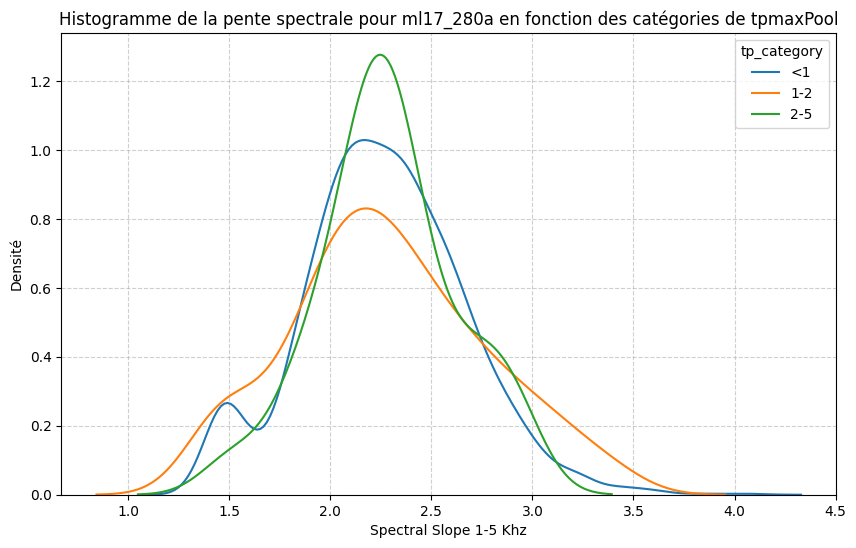

In [123]:
depif = "ml17_280a"
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
feat = "tpmaxPool"

if feat == "precipitation_GPM" :
    df['tp_category'] = pd.cut(df['precipitation_GPM'], bins=[0, 1, 2, 5, float('inf')], 
                            labels=['<1', '1-2', '2-5', '>5'], right=False)
else :
    df['tp_category'] = pd.cut(df['tpmaxPool'], bins=[0, 0.001, 0.002, 0.005, float('inf')], 
                            labels=['<1', '1-2', '2-5', '>5'], right=False)

# plt.figure(figsize=(10, 6))
# sns.kdeplot(data=df, x='SpecSlope1-5', hue='tp_category')
# # sns.kdeplot(data=df, x='SpecSlope1-5', hue='tp_category',common_norm=False)
# plt.title(f"Histogramme de la pente spectrale pour {depid} en fonction des catégories de tp")
# plt.xlabel("Spectral Slope 1-5 Khz")
# plt.ylabel("densité")
# plt.legend(title='tp_category', loc='upper right')
# plt.grid(True, linestyle="--", alpha=0.6)
# plt.show()

plt.figure(figsize=(10, 6))
for category in df['tp_category'].unique():
    sns.kdeplot(data=df[df['tp_category'] == category], x='SpecSlope1-5', label=category)
plt.title(f"Histogramme de la pente spectrale pour {depid} en fonction des catégories de {feat}")
plt.xlabel("Spectral Slope 1-5 Khz")
plt.ylabel("Densité")
plt.legend(title='tp_category', loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### All Models

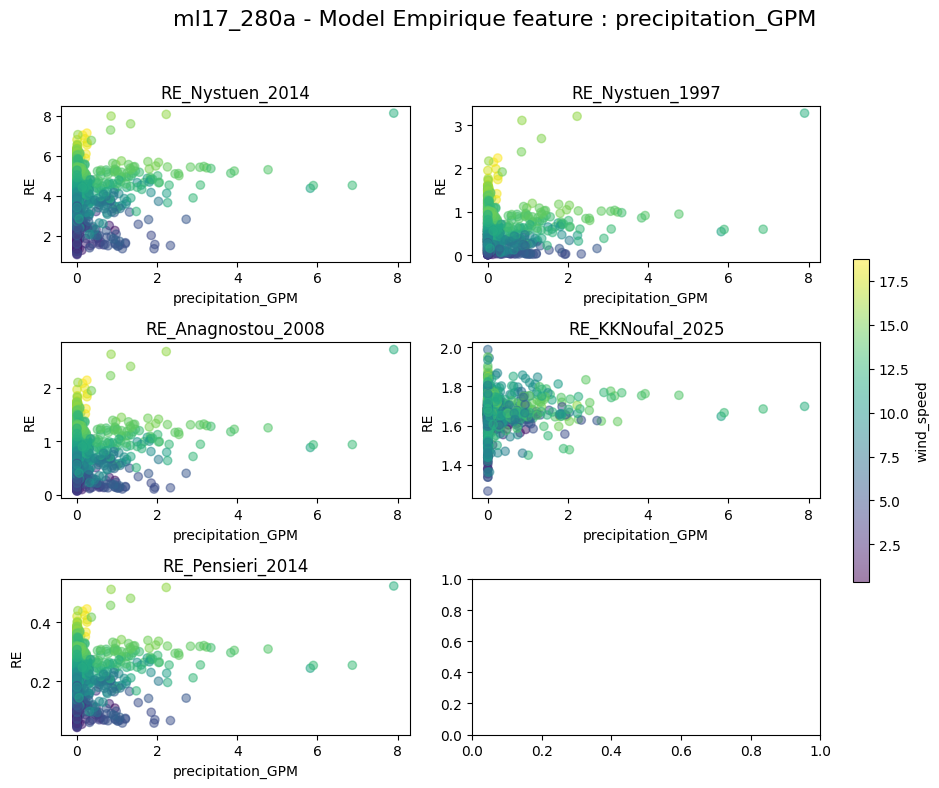

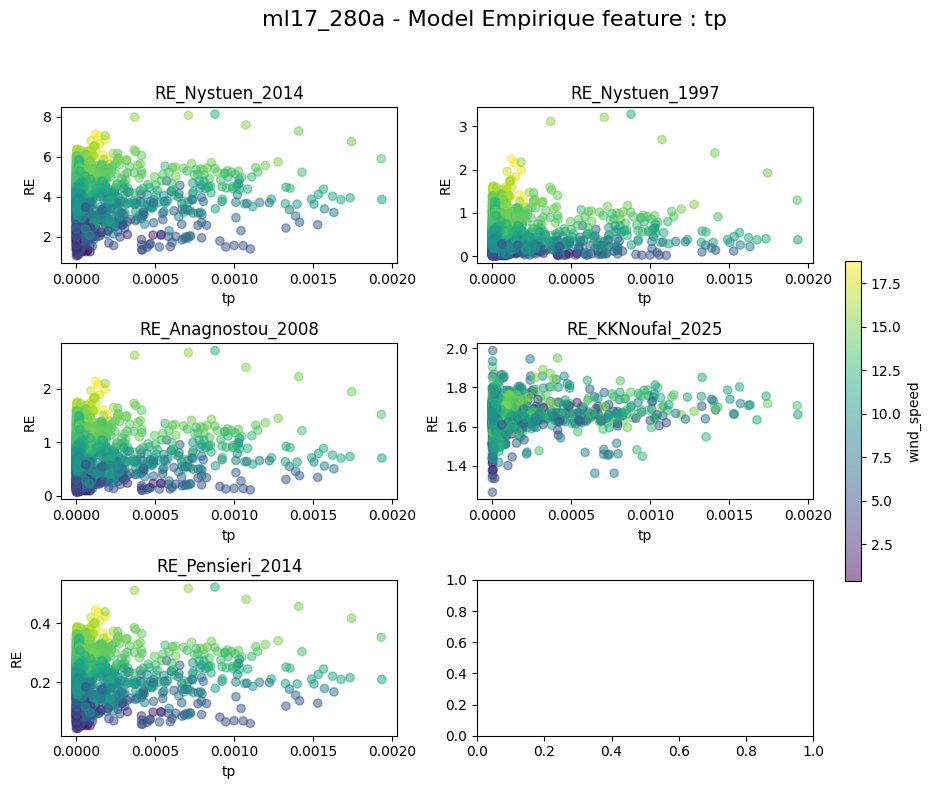

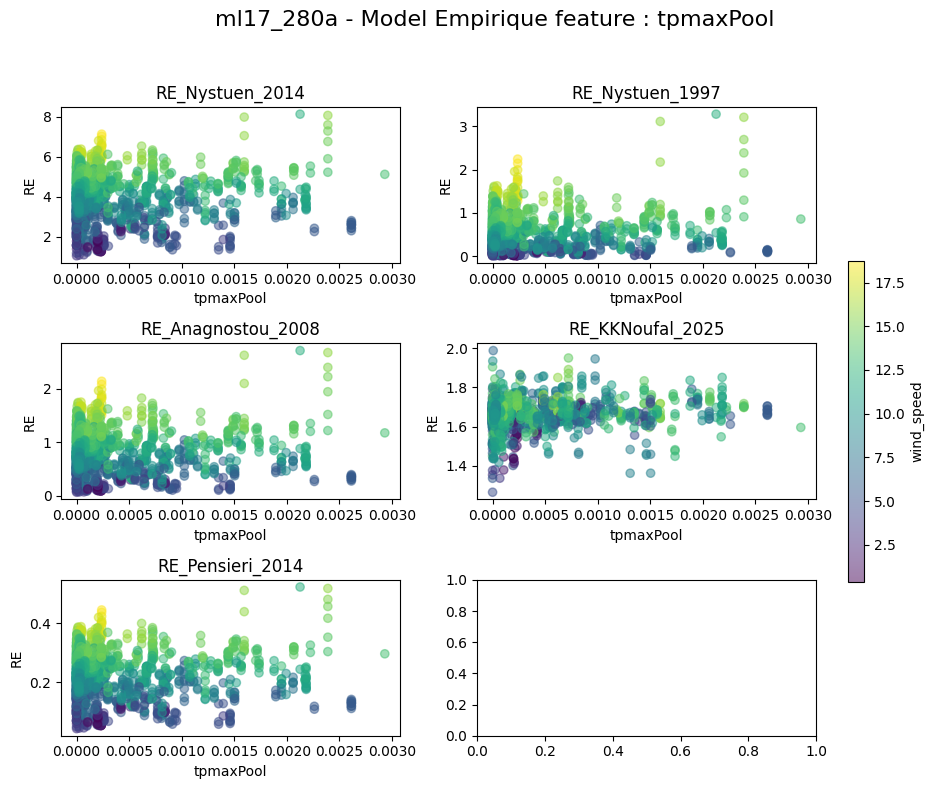

In [143]:
depid = depids[0]
df = pd.read_csv(path + f'/{depid}/{depid}_dive.csv')
features = ['precipitation_GPM','tp','tpmaxPool']

for feature in features:
    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    fig.suptitle(f"{depid} - Model Empirique feature : {feature}", fontsize=16)

    # -------- Plot 1: Nystuen 2014
    rslts = RE_Nystuen_2014(df)
    sc1 = axs[0, 0].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[0, 0].set_title('RE_Nystuen_2014')
    axs[0, 0].set_xlabel(feature)
    axs[0, 0].set_ylabel('RE')

    # -------- Plot 2: Nystuen 1997
    rslts = RE_Nystuen_1997(df)
    sc2 = axs[0, 1].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[0, 1].set_title('RE_Nystuen_1997')
    axs[0, 1].set_xlabel(feature)
    axs[0, 1].set_ylabel('RE')

    # -------- Plot 3: Anagnostou 2008
    rslts = RE_Anagnostou_2008(df)
    sc3 = axs[1, 0].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[1, 0].set_title('RE_Anagnostou_2008')
    axs[1, 0].set_xlabel(feature)
    axs[1, 0].set_ylabel('RE')

    # -------- Plot 4: KKNoufal 2025
    rslts = RE_KKNoufal_2025(df)
    sc4 = axs[1, 1].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[1, 1].set_title('RE_KKNoufal_2025')
    axs[1, 1].set_xlabel(feature)
    axs[1, 1].set_ylabel('RE')

    # -------- Plot 5: Pensieri 2014
    rslts = RE_Pensieri_2014(df)
    sc5 = axs[2, 0].scatter(df[feature], rslts, c=df['wind_speed'], cmap='viridis', alpha=0.5)
    axs[2, 0].set_title('RE_Pensieri_2014')
    axs[2, 0].set_xlabel(feature)
    axs[2, 0].set_ylabel('RE')

    # -------- Layout + colorbar
    fig.tight_layout(rect=[0, 0, 0.9, 0.95])
    cbar = fig.colorbar(sc4, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('wind_speed')

    plt.show()
